# Generování textu znakovou RNN

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import random
import tqdm

from IPython.core.debugger import set_trace

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch import optim

V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru, který si stáhněte [odsud](https://1drv.ms/t/s!AotVPA94wWKxoWLULaBqvPXiNS5t) a uložte jako `data/headlines.txt`.

Z textu byly odstraneny hacky, carky a vsechny nestandardni znaky. Neni tedy potreba resit kodovani apod.

In [5]:
data = open('data/headlines.txt').read()
lines = [line for line in data.split('\n') if line]

Ukázka dat:

In [6]:
for i in range(10):
    print(i, random.choice(lines))

0 rus je nominovany na cenu fsb jejiz sidlo zapalil
1 s novymi pocitaci se roztrhl pytel
2 bankovni lupice s maskami klause a schwarzeneggera odhalili
3 za polakem prisel exekutor muz se zapalil a pak i obesil
4 muz koupil tank nasel v nem zlato za desitky milionu
5 macron s mayovou ohlasili akcni plan v boji proti terorismu
6 chlebicek fenomen ktery milovaly hvezdy cernobileho filmu
7 travel service loni prepravil 6 3 milionu cestujicich je to narust o desetinu
8 konta chrani pred hackery i analyza chovani v on line bankovnictvi
9 tragedie varsavskeho povstani


Sada znaků = náš slovník:

In [7]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [8]:
chr2idx = {c: i for i, c in enumerate(chars)}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [9]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

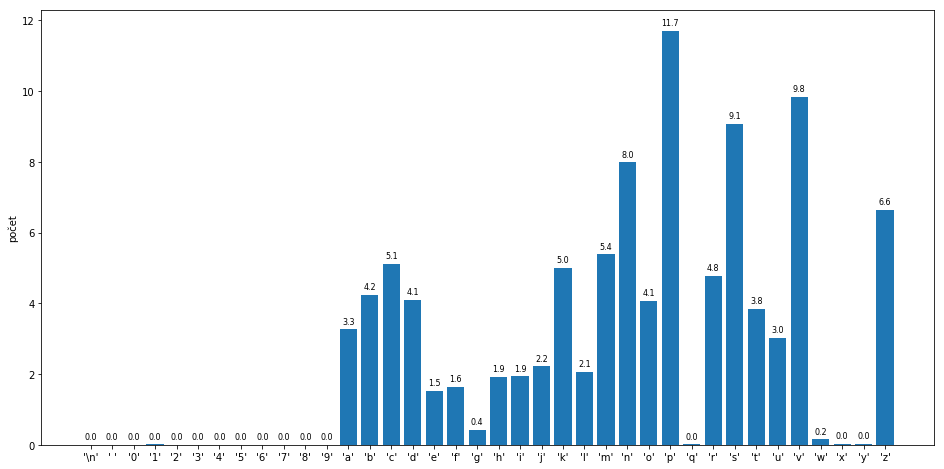

In [10]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet')
plt.show()

Funkce pro zobrazení průběhu lossu:

In [11]:
def plot_history(history, avg_range=1):
    if avg_range > 1:
        y = np.mean(np.reshape(history[:avg_range * (len(history) // avg_range)], (-1, avg_range)), axis=1)
    else:
        y = history
    plt.plot(y)
    plt.show()

# Sekvenční data a PyTorch

Následující funkce převede řetězec na sekvenci čísel odpovídajících indexům znaků v tabulce. Pokud např. `chars = ['a', 'b', 'c']`, pak řetězec `'acba'` převede na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `Variable`.

In [12]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    x = Variable(tensor)
    return x

In [13]:
x = char_tensor('abca')
x

Variable containing:
 12
 13
 14
 12
[torch.LongTensor of size 4]

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [14]:
def to_string(indices):
    if isinstance(indices, Variable):
        indices = indices.data
    return ''.join([chars[i] for i in indices])

In [15]:
to_string(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [16]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e

Variable containing:

Columns 0 to 9 
-1.0628  0.6801  1.0463 -0.9462  1.1927  0.9439 -1.6810  1.5004  1.1225 -0.5741
 0.2352  0.8074  0.2851 -1.5848  0.5096 -0.4766 -0.2326  0.0068  0.6137  1.6585
 1.5313 -0.8152 -0.0674  0.2330  0.3642 -1.6706  0.1782 -0.5925 -0.0653 -1.1307
-1.0628  0.6801  1.0463 -0.9462  1.1927  0.9439 -1.6810  1.5004  1.1225 -0.5741

Columns 10 to 19 
-0.8198 -1.0346  0.0443 -2.9094 -0.6997  1.0253 -0.0678 -0.5041 -1.4731 -0.5609
-0.0478  1.0718 -0.0676  0.0372  0.9000  0.1579  0.4791  0.3598 -0.6496 -1.8614
 0.8821 -0.9065  0.5513 -0.4072 -0.2950 -0.8295  0.1658  0.3496 -0.3423  1.6806
-0.8198 -1.0346  0.0443 -2.9094 -0.6997  1.0253 -0.0678 -0.5041 -1.4731 -0.5609

Columns 20 to 29 
 1.0289 -1.5741  0.0162 -0.4120  0.6443 -0.2150 -0.9762 -1.1878 -1.5184 -0.6756
-0.1635  0.9849  0.5628  0.2358  0.0905  0.5087  0.2538  0.1835  0.3386 -1.0883
 0.6539 -0.0146 -0.4550 -1.5847 -0.4738 -1.4739 -0.4049  0.7450  0.3434 -0.7464
 1.0289 -1.5741  0.0162 -0.4120  0.6443 -0.2

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. `output` tedy **neprochází žádnou lineární vrstvou**, jak by se mohlo na první pohled zdát. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami.

**Příklad:** porovnejme `output` a `hidden`.
tensory by měly být tvaru `(seq, batch, dim)`
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [17]:
# do site posleme pouze jeden znak
e0 = e[0].view(1, 1, -1)
e0.shape

torch.Size([1, 1, 30])

In [18]:
# RNN ocekava na vstupu vektor o rozmeru 6 a skryty stav bude mit rozmer 8
rnn = nn.RNN(30, 8)

# inicializace skryteho stavu a vstupu
# tensory by mely byt tvaru (seq, batch, dim)
h = Variable(torch.rand(8))
o, h = rnn(e0)

print(o)
print(h)

Variable containing:
(0 ,.,.) = 
 -0.5174 -0.6365 -0.9333  0.5104  0.8906  0.3187  0.5204  0.7961
[torch.FloatTensor of size 1x1x8]

Variable containing:
(0 ,.,.) = 
 -0.5174 -0.6365 -0.9333  0.5104  0.8906  0.3187  0.5204  0.7961
[torch.FloatTensor of size 1x1x8]



Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků a skrytý stav z posledního kroku.

In [19]:
class RNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.emb = nn.Embedding(voc_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeddings = self.emb(x)
        embeddings = embeddings.view(batch_size, 1, -1)
        output, hidden = self.rnn(embeddings, hidden)
        score = self.fc(output.view(batch_size, -1))
        return score, hidden

    def init_hidden(self):
        h = Variable(torch.zeros(self.rnn.num_layers, 1, self.rnn.hidden_size))
        c = Variable(torch.zeros(self.rnn.num_layers, 1, self.rnn.hidden_size))
        
        return h, c

In [52]:
voc_size = len(chars)
emb_dim = 100
hidden_dim = 200
output_dim = voc_size

rnn = RNN(voc_size, emb_dim, hidden_dim, output_dim, n_layers=1)
rnn_history = []
example_history = []

Vytvoříme trénovací data. `y_train` je v tomto případě stejného rozměru jako `X_train` a ke každému znaku udává následjící. Poslední znak má jako label `\n`, značící konec sekvence. Data vytvoříme jako seznamy, tj. `list`, kde každý prvek je jedna věta, už převedená na indexy znaků metodou `char_tensor`.

In [50]:
X_train = [char_tensor(line) for line in lines]
y_train = [char_tensor(line[1:] + '\n') for line in lines]

In [51]:
idx = random.randrange(len(X_train))
print(to_string(X_train[idx].data))
print('data:  {} ... {}'.format(to_string(X_train[idx].data.numpy()[:10]), to_string(X_train[idx].data.numpy()[-10:])))
print('label: {} ... {}'.format(to_string(y_train[idx].data.numpy()[:10]), to_string(y_train[idx].data.numpy()[-10:])))

skolou v usa prosvistela srnka studenti jen nevericne koukali
data:  skolou v u ... ne koukali
label: kolou v us ... e koukali



Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme náš model `rnn`, nějaký inicializační text `init_text`, příp. i inicializační `hidden`, a vygeneruje text - vrací tedy string.

In [53]:
def sample(rnn, init_text='', hidden=None, maxlen=150, mode='multinomial'):
    # vystupni text bude pole (na konci prevedeme na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        s = np.random.choice(len(chars), p=p0)
        out_text = [chars[s]]
    
    # to same hidden
    if hidden is None:
        hidden = rnn.init_hidden()
        
        # sit projedeme vstupem, abychom ziskali aktualni hidden stav
        x = char_tensor(out_text)
        for i in range(len(out_text)):
            score, hidden = rnn(x[i], hidden)
    
    # nasledujici znak je posledni znak prozatimniho vystupu
    x = char_tensor(out_text[-1])

    while True:
        # dopredny pruchod
        score, hidden = rnn(x, hidden)
        
        # pravdepodobnosti znaku
        ...
        
        # vybrat nasledujici znak --> index do `k`
        if mode == 'multinomial':
            k = torch.multinomial(score.data.view(-1).div(0.9).exp(), 1)[0]
        elif mode == 'argmax':
            k = np.argmax(score.data.numpy().flatten())
        elif mode == 'proportional':
            pass
           # k = ...
        
        # zastavit, pokud end-token
        if k == chr2idx['\n']:
            break
        
        # pridat znak
        out_text.append(chars[k])
        
        # zastavit, pokud text je moc dlouhy
        if len(out_text) == maxlen:
            break
        
        # novy vstupni znak
        x = char_tensor(chars[k])
    
    return ''.join(out_text)

In [54]:
print(sample(rnn, init_text='prezident', mode='multinomial'))

prezidenth 8bb


# Trénování

In [55]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [56]:
example = sample(rnn, mode='argmax')
smooth_loss = -np.log(1. / len(chars))
max_per_epoch = 10000

for epoch in range(1):
    if max_per_epoch < len(lines):
        perm = np.random.permutation(len(lines))
    else:
        perm = np.arange(len(lines))
    
    pb = tqdm.tqdm_notebook(perm, desc='ep {:03d}'.format(epoch))
    
    for li in enumerate(pb):
        hidden = rnn.init_hidden()
        rnn.zero_grad()
        loss = 0.
    
        x = X_train[li[1]]
        y = y_train[li[1]]
        
        for ic, c in enumerate(lines[li[1]]):
            
            # dopredny pruchod
            score, hidden = rnn(x[ic], hidden)
            
            # loss
            loss += criterion(score.view(1, -1), y[ic])
        
        loss /= len(x)

        loss.backward()
        optimizer.step()
        
        if li[0] % 100 == 0:
            example = sample(rnn)
            example_history.append(example)
        
        rnn_history.append(float(loss))
        smooth_loss = 0.99 * smooth_loss + 0.01 * float(loss)
        pb.set_postfix(loss='{:.3f}'.format(smooth_loss), ex=example[:40])

HBox(children=(IntProgress(value=0, description='ep 000', max=88034), HTML(value='')))

In [ ]:
# Se mi o těch sítích i zdá:
# že přidává i 1D konvoluční vrstva při vstupu z venčí sice by mě zajmalo jak by vypadali ty filtry, ale asi by to nefungovalo

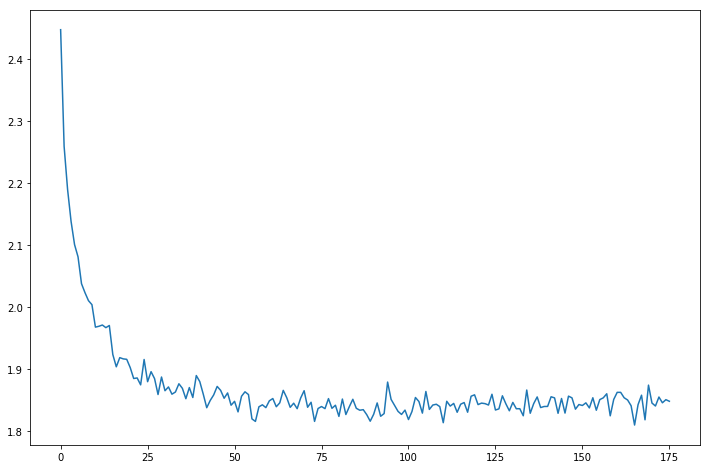

In [57]:
plot_history(rnn_history, avg_range=500)

In [68]:
print(example_history)

['zlp08o2u8e95er8myi51', 'pitbhazn vdi olakuznuuti', 'vrojsky vydoni dastky se podeti umsku', 'vybreninkyr perste zasenech verusi marodedl hdlaljazike', 'kovce', 'menl krezij povalipo s lidne castali prvyno nejruve enym petsidi isrdilove se nestre na tasil nosak', 'ne letnihou crazstinovi toud v zakovka chlilanikych prospeta uonici ukolice prprechat winea vurlaoatit frvel pride vech rozazili use cesek shod', 'tibou pisto deleti uchodpovansi zemesleti do dlil o v jegou prd d', 'sefarske jecni davat dvazalice', 'onstvi na trititiny san z 4guriky strafik ucekala krati skoliky din okazoske jedesto zachtrani dvem stan hynmosila odmites pochati vyseny z dvebil', 'proti v nemamskym votat cistnuji k vyranent vlistka', 'reny v rapu cesky', 'fi do vladu je klidu', 'lovalo po vlaali dve hodnici po do kianistu usad', 'ta probesli zabryvli vyfbilarsajch vezdy byzni zudana 5500 nejvydi', 'oistalsky nejlencieho', 'trem vysvesti kusti pripsce chtaji k poli vysobbilm pli bohl bahou', 'ckova tras toky s

In [67]:
print(sample(rnn, init_text='kolecko', mode='multinomial'))

koleckova turistovanske sproplate tisic poslou jestuje serrestu
